In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import root_scalar

# Load data (fixed separator warning)
df = pd.read_csv("data.csv", sep=";", index_col=0, parse_dates=True, dayfirst=False)
returns = df.pct_change().dropna()
returns = returns[(returns.index >= "2021-10-01") & (returns.index < "2024-01-01")]
prices = df.loc[returns.index]

# Parameters
window = 90
vol_target_annual = 0.2495
risk_free_rate_annual = 0.05
risk_free_rate_daily = risk_free_rate_annual / 365
transaction_fee = 0.001
initial_portfolio_value = 1_000_000
rebalance_freq = 30
n_assets = returns.shape[1]

def run_strategy_for_gamma(gamma):
    weights_history = []
    weights_rf_history = []
    portfolio_returns = []
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    total_fees = 0.0

    prices_today = prices.iloc[window]
    current_w = np.ones(n_assets) / n_assets
    asset_values = current_w * portfolio_value
    delta = asset_values / prices_today.values
    delta_0 = 0.0

    for t in range(window, len(returns) - 1):
        rebalance_today = (t - window) % rebalance_freq == 0
        window_returns = returns.iloc[t - window:t]

        # Fix: skip invalid windows
        if window_returns.shape[1] == 0 or window_returns.isnull().values.any():
            continue

        prices_today = prices.iloc[t]
        prices_next = prices.iloc[t + 1]

        # Calculation of the new portfolio value
        risky_value = np.sum(delta * prices_today.values)
        rf_value = delta_0 * (1 + risk_free_rate_daily)
        portfolio_value = risky_value + rf_value

        # Update the weights
        pre_rebalance_w = (delta * prices_today.values) / portfolio_value if portfolio_value > 1e-12 else np.zeros(n_assets)
        pre_rebalance_w_rf = rf_value / portfolio_value if portfolio_value > 1e-12 else 0.0

        if rebalance_today:
            mu = window_returns.mean().values
            Sigma = window_returns.cov().values

            w = cp.Variable(n_assets)
            w_rf = cp.Variable(1)

            risk_term = 0.5 * cp.quad_form(w, Sigma)
            expected_return = mu.T @ w + risk_free_rate_daily * w_rf
            objective = cp.Minimize(risk_term - gamma * expected_return)

            constraints = [
                w >= 0,
                w_rf >= 0,
                cp.sum(w) + w_rf == 1
            ]

            prob = cp.Problem(objective, constraints)
            try:
                prob.solve(solver=cp.SCS, verbose=False)
                new_w = w.value
                new_w_rf = w_rf.value[0]
            except:
                new_w = pre_rebalance_w
                new_w_rf = pre_rebalance_w_rf
        else:
            new_w = pre_rebalance_w
            new_w_rf = pre_rebalance_w_rf

        # Calculation of the fees
        if rebalance_today:
            target_risky_values = new_w * portfolio_value
            current_risky_values = delta * prices_today.values
            delta_s = target_risky_values - current_risky_values
            fees = np.sum(np.abs(delta_s)) * transaction_fee
            total_fees += fees

            # Update the number of units held
            delta = target_risky_values / prices_today.values
            delta_0 = (new_w_rf * portfolio_value - fees) / (1 + risk_free_rate_daily)
        else:
            delta_0 *= (1 + risk_free_rate_daily)

        # Calculation of the new portfolio value
        risky_value_next = delta * prices_next.values
        rf_value_next = delta_0 * (1 + risk_free_rate_daily)
        prev_portfolio_value = portfolio_value
        portfolio_value = np.sum(risky_value_next) + rf_value_next
        portfolio_values.append(portfolio_value)
        net_return = (portfolio_value - prev_portfolio_value) / prev_portfolio_value

        # Storage
        weights_history.append(risky_value_next / portfolio_value)
        weights_rf_history.append(rf_value_next / portfolio_value)
        portfolio_returns.append(net_return)

    return np.array(portfolio_returns), portfolio_value, np.array(weights_history), np.array(portfolio_values), total_fees, np.array(weights_rf_history)

# Goal function to find the optimal gamma
def objective_gamma(gamma):
    rets = run_strategy_for_gamma(gamma)[0]
    vol_annual = np.std(rets) * np.sqrt(365)
    return vol_annual - vol_target_annual

gamma_init = 1.0
result = root_scalar(objective_gamma, method='brentq', bracket=[1e-4, 1e4], xtol=1e-4)
gamma_opt = result.root

# Calculation of the performance metrics
final_returns, portfolio_value, weights_hist, portfolio_values, total_fees, weights_rf_history = run_strategy_for_gamma(gamma_opt)
T = len(final_returns)
annual_ret = (365 / T) * (portfolio_value - initial_portfolio_value) / initial_portfolio_value
annual_cumulative = (1 + final_returns).cumprod() - 1
annual_vol = np.std(final_returns, ddof=1) * np.sqrt(365)
r_bar = np.mean(final_returns) * 365
sharpe = ((r_bar - risk_free_rate_annual) / annual_vol)

# Calculation of the diversification
diversification_scores = []
for w in weights_hist:
    H_x = np.sum(w**2) / (np.sum(w))**2
    D_x = 1 / (len(w) * H_x)
    diversification_scores.append(D_x)
avg_diversification = np.mean(diversification_scores)

# Calculation of the maximum drawdown
cum_max = np.maximum.accumulate(portfolio_values)
drawdowns = (cum_max - portfolio_values) / cum_max
max_drawdown = np.max(drawdowns)

# Calculation of the fee cost
fee_cost = total_fees / initial_portfolio_value
avg_risk_free_allocation = np.mean(weights_rf_history) * 100

# Display results
print(f"Average risk-free asset allocation : {avg_risk_free_allocation:.1f}%")
print(f"Optimal gamma : {gamma_opt:.1f}")
print(f"Annualized volatility : {annual_vol:.1%}")
print(f"Annualized return : {annual_ret:.1%}")
print(f"Sharpe Ratio : {sharpe:.1f}")
print(f"Final value of the portfolio : {portfolio_value:.1f} €")
print(f"Total return : {annual_cumulative[-1]:.1%}")
print(f"Diversification mean : {avg_diversification:.1%}")
print(f"Maximum Drawdown : {max_drawdown:.1%}")
print(f"Fee cost : {fee_cost:.2%}")


Average risk-free asset allocation : 76.8%
Optimal gamma : 0.1
Annualized volatility : 25.0%
Annualized return : 12.6%
Sharpe Ratio : 0.4
Final value of the portfolio : 1252181.9 €
Total return : 25.2%
Diversification mean : 9.9%
Maximum Drawdown : 29.4%
Fee cost : 0.66%


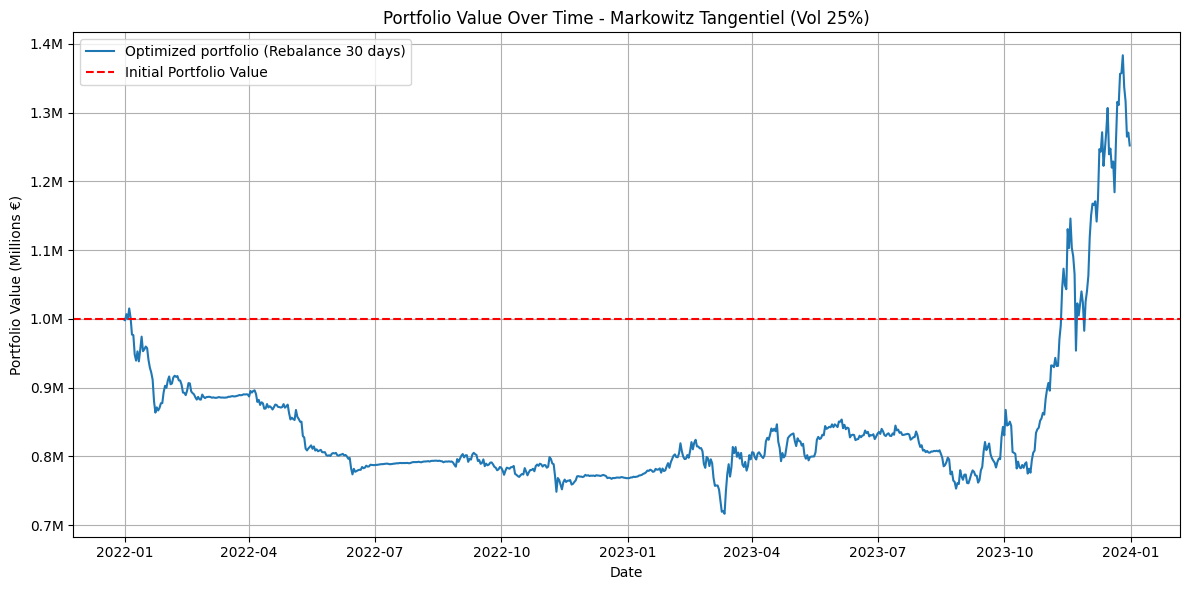

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(returns[(returns.index >= "2021-12-31") & (returns.index < "2024-01-01")].index, 
         portfolio_values[1:], 
         label=f"Optimized portfolio (Rebalance {rebalance_freq} days)")

plt.title("Portfolio Value Over Time - Markowitz Tangentiel (Vol 25%)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Millions €)")
plt.ticklabel_format(axis='y', style='plain', useMathText=True)  
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.axhline(y=initial_portfolio_value, color='r', linestyle='--', label='Initial Portfolio Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

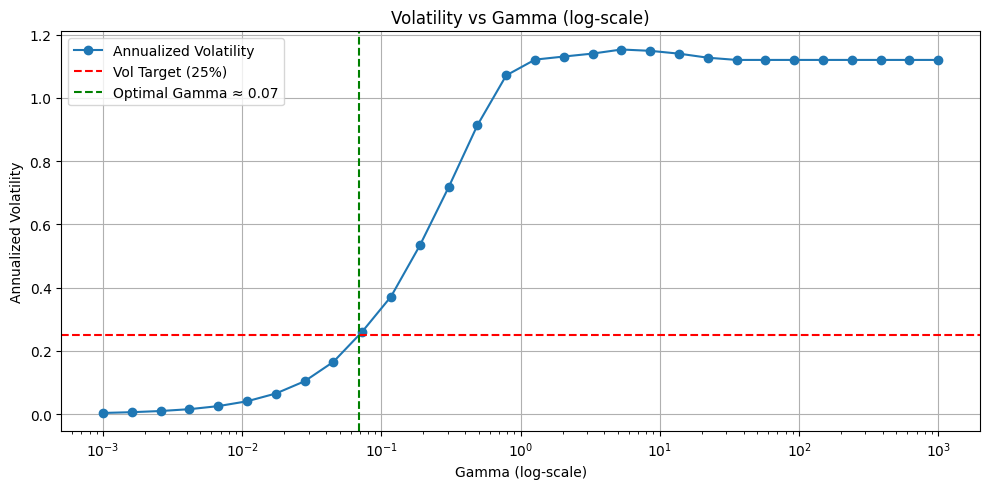

In [7]:
gamma_grid = np.logspace(-3, 3, 30)
vols = []
rets = []

for g in gamma_grid:
    returns_gamma = run_strategy_for_gamma(g)[0]
    portfolio_value = run_strategy_for_gamma(g)[1]
    vol = np.std(returns_gamma) * np.sqrt(365)
    ret = (365 / T) * (portfolio_value - initial_portfolio_value) / initial_portfolio_value
    vols.append(vol)
    rets.append(ret)

plt.figure(figsize=(10, 5))
plt.plot(gamma_grid, vols, marker='o', label="Annualized Volatility")
plt.axhline(vol_target_annual, color='r', linestyle='--', label="Vol Target (25%)")
plt.axvline(gamma_opt, color='g', linestyle='--', label=f"Optimal Gamma ≈ {gamma_opt:.2f}")
plt.xscale('log')
plt.xlabel("Gamma (log-scale)")
plt.ylabel("Annualized Volatility")
plt.title("Volatility vs Gamma (log-scale)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

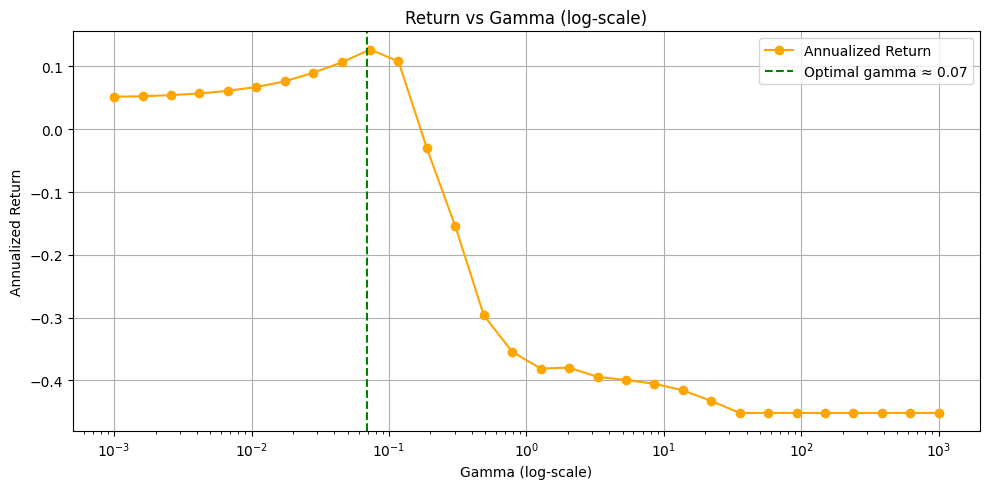

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(gamma_grid, rets, marker='o', color='orange', label="Annualized Return")
plt.axvline(gamma_opt, color='g', linestyle='--', label=f"Optimal gamma ≈ {gamma_opt:.2f}")
plt.xscale('log')
plt.xlabel("Gamma (log-scale)")
plt.ylabel("Annualized Return")
plt.title("Return vs Gamma (log-scale)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

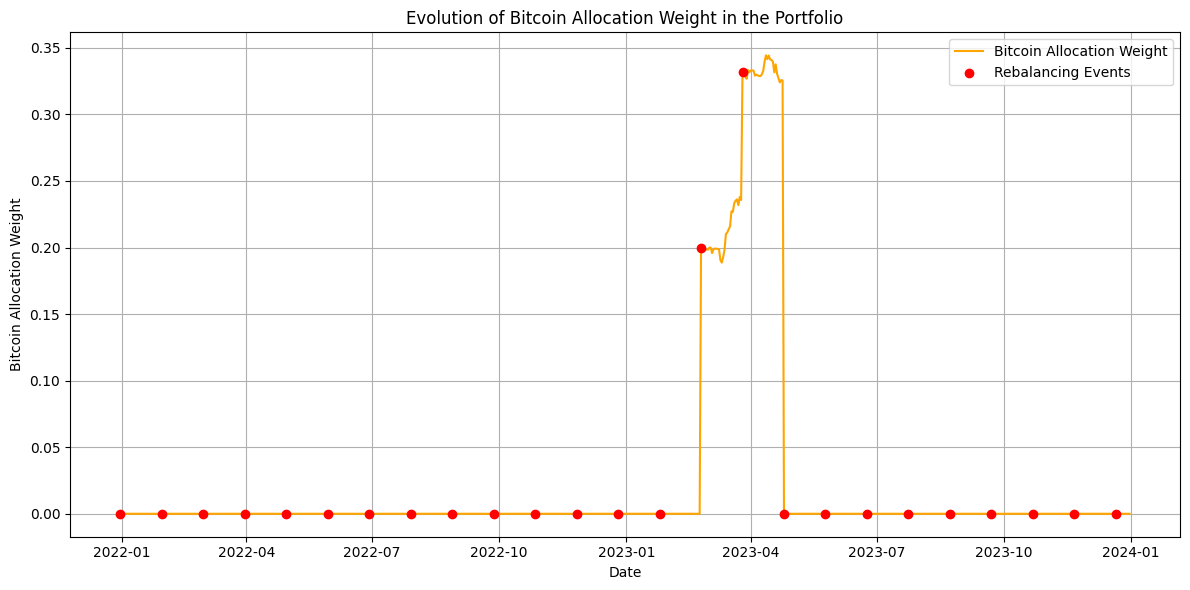

In [9]:
#Creation of the time index
dates_weights = returns.index[window+1 : len(returns)]

#Extraction of the Bitcoin weights
bitcoin_weights = weights_hist[:, 0]

#Identification of rebalancing dates
rebalance_indices = [i for i in range(len(bitcoin_weights)) if (i * 1) % rebalance_freq == 0]
rebalance_dates = [dates_weights[i] for i in rebalance_indices]
rebalance_values = [bitcoin_weights[i] for i in rebalance_indices]

#Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_weights, bitcoin_weights, label="Bitcoin Allocation Weight", color='orange')
plt.scatter(rebalance_dates, rebalance_values, color='red', label="Rebalancing Events", zorder=5)
plt.title("Evolution of Bitcoin Allocation Weight in the Portfolio")
plt.xlabel("Date")
plt.ylabel("Bitcoin Allocation Weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


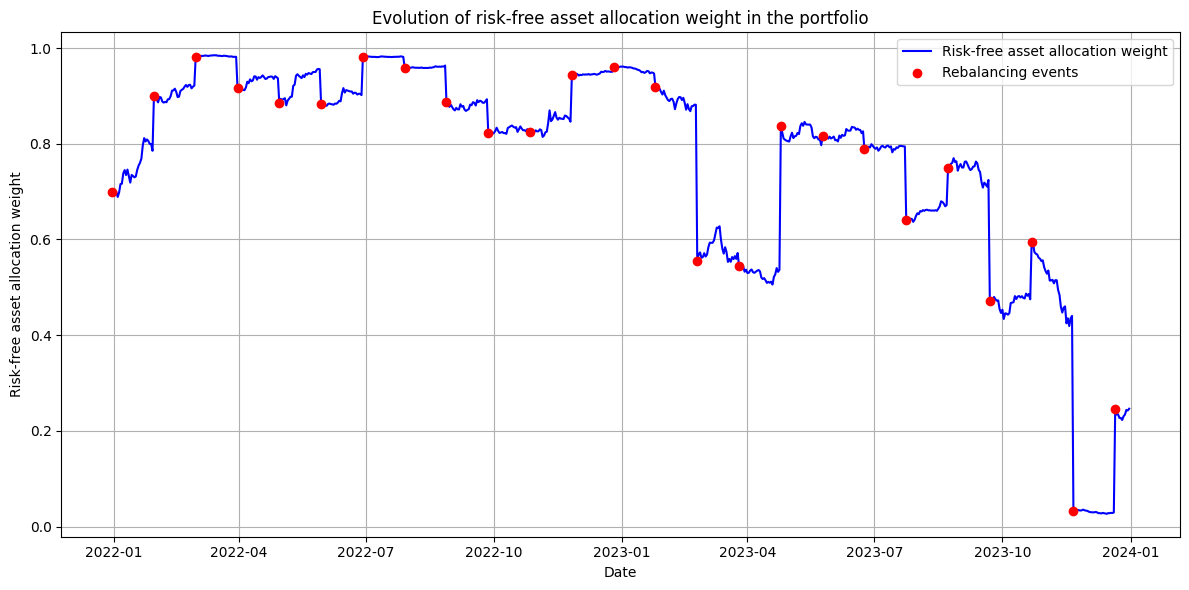

In [10]:
rf_weights = weights_rf_history

#Identification of rebalancing indices (same indices as for Bitcoin)
rebalance_values_rf = [rf_weights[i] for i in rebalance_indices]

#Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_weights, rf_weights, label="Risk-free asset allocation weight", color='blue')
plt.scatter(rebalance_dates, rebalance_values_rf, color='red', label="Rebalancing events", zorder=5)
plt.title("Evolution of risk-free asset allocation weight in the portfolio")
plt.xlabel("Date")
plt.ylabel("Risk-free asset allocation weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()